<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:27] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


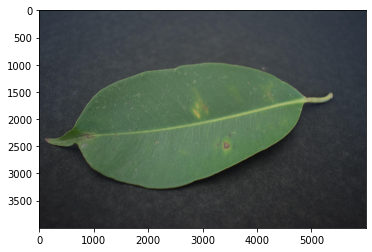

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

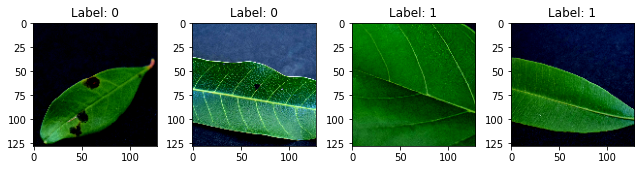

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2558537135274146 samples/sec                   batch loss = 1.7812193632125854 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2670180720503128 samples/sec                   batch loss = 1.257574439048767 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2636438373394905 samples/sec                   batch loss = 0.5124288201332092 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2625290681967627 samples/sec                   batch loss = 0.530115008354187 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2663870541387272 samples/sec                   batch loss = 0.2285163849592209 | accuracy = 0.66


Epoch[1] Batch[30] Speed: 1.260214066127449 samples/sec                   batch loss = 1.1840156316757202 | accuracy = 0.65


Epoch[1] Batch[35] Speed: 1.2631342778698516 samples/sec                   batch loss = 0.28545093536376953 | accuracy = 0.6642857142857143


Epoch[1] Batch[40] Speed: 1.2651320536689 samples/sec                   batch loss = 0.5271154642105103 | accuracy = 0.68125


Epoch[1] Batch[45] Speed: 1.2594611134282636 samples/sec                   batch loss = 0.8387649655342102 | accuracy = 0.6666666666666666


Epoch[1] Batch[50] Speed: 1.264054942924627 samples/sec                   batch loss = 0.5646868944168091 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2671243874612115 samples/sec                   batch loss = 0.3906557559967041 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2652590448227914 samples/sec                   batch loss = 0.3686258792877197 | accuracy = 0.6458333333333334


Epoch[1] Batch[65] Speed: 1.2726379015922296 samples/sec                   batch loss = 0.32263967394828796 | accuracy = 0.6461538461538462


Epoch[1] Batch[70] Speed: 1.2689824725045362 samples/sec                   batch loss = 0.16516338288784027 | accuracy = 0.6535714285714286


Epoch[1] Batch[75] Speed: 1.2650493466195107 samples/sec                   batch loss = 0.5761568546295166 | accuracy = 0.65


Epoch[1] Batch[80] Speed: 1.2676512516204337 samples/sec                   batch loss = 0.6463875770568848 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2620276220793092 samples/sec                   batch loss = 1.2805085182189941 | accuracy = 0.6441176470588236


Epoch[1] Batch[90] Speed: 1.2683328128374765 samples/sec                   batch loss = 0.3360055088996887 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.2592461493173348 samples/sec                   batch loss = 0.2936917841434479 | accuracy = 0.65


Epoch[1] Batch[100] Speed: 1.2693968675801637 samples/sec                   batch loss = 0.7474494576454163 | accuracy = 0.6425


Epoch[1] Batch[105] Speed: 1.2743735714564048 samples/sec                   batch loss = 0.554473340511322 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.2709661642663794 samples/sec                   batch loss = 0.687174379825592 | accuracy = 0.6454545454545455


Epoch[1] Batch[115] Speed: 1.2755580466095393 samples/sec                   batch loss = 1.0204851627349854 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.2723355258093771 samples/sec                   batch loss = 0.8991886377334595 | accuracy = 0.6375


Epoch[1] Batch[125] Speed: 1.2599342172159604 samples/sec                   batch loss = 0.9702343344688416 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.270326880268936 samples/sec                   batch loss = 0.7199156880378723 | accuracy = 0.6384615384615384


Epoch[1] Batch[135] Speed: 1.2679868615367407 samples/sec                   batch loss = 0.24437858164310455 | accuracy = 0.6425925925925926


Epoch[1] Batch[140] Speed: 1.2707412877668962 samples/sec                   batch loss = 2.2566397190093994 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2689563658441008 samples/sec                   batch loss = 0.7493332624435425 | accuracy = 0.6517241379310345


Epoch[1] Batch[150] Speed: 1.2694182859858085 samples/sec                   batch loss = 2.0896260738372803 | accuracy = 0.6516666666666666


Epoch[1] Batch[155] Speed: 1.2691652492095715 samples/sec                   batch loss = 0.5747718811035156 | accuracy = 0.6548387096774193


Epoch[1] Batch[160] Speed: 1.270748795201438 samples/sec                   batch loss = 0.6535080671310425 | accuracy = 0.6484375


Epoch[1] Batch[165] Speed: 1.26999551037349 samples/sec                   batch loss = 0.5466702580451965 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.2665286389412418 samples/sec                   batch loss = 0.4132854640483856 | accuracy = 0.6514705882352941


Epoch[1] Batch[175] Speed: 1.2681391565444986 samples/sec                   batch loss = 0.6706744432449341 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2754110424224363 samples/sec                   batch loss = 0.22050662338733673 | accuracy = 0.6527777777777778


Epoch[1] Batch[185] Speed: 1.2735552693249674 samples/sec                   batch loss = 0.7485555410385132 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2695382616289668 samples/sec                   batch loss = 0.5683879852294922 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.2737295988186816 samples/sec                   batch loss = 0.42408180236816406 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.2591761174959732 samples/sec                   batch loss = 0.4802747070789337 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.2733985778832557 samples/sec                   batch loss = 0.21046747267246246 | accuracy = 0.6573170731707317


Epoch[1] Batch[210] Speed: 1.2717968559421493 samples/sec                   batch loss = 0.46240106225013733 | accuracy = 0.6571428571428571


Epoch[1] Batch[215] Speed: 1.2649827691011295 samples/sec                   batch loss = 0.4762764871120453 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2636530695219421 samples/sec                   batch loss = 0.8442534804344177 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.2655544383939696 samples/sec                   batch loss = 0.3764497637748718 | accuracy = 0.6622222222222223


Epoch[1] Batch[230] Speed: 1.26762462504234 samples/sec                   batch loss = 0.39146366715431213 | accuracy = 0.6619565217391304


Epoch[1] Batch[235] Speed: 1.2684842318938059 samples/sec                   batch loss = 0.8383330702781677 | accuracy = 0.6585106382978724


Epoch[1] Batch[240] Speed: 1.2666140257672647 samples/sec                   batch loss = 0.3142019808292389 | accuracy = 0.659375


Epoch[1] Batch[245] Speed: 1.269955134683378 samples/sec                   batch loss = 0.2527182698249817 | accuracy = 0.6612244897959184


Epoch[1] Batch[250] Speed: 1.2714860143265232 samples/sec                   batch loss = 0.5410727262496948 | accuracy = 0.663


Epoch[1] Batch[255] Speed: 1.267900714608572 samples/sec                   batch loss = 0.3854474425315857 | accuracy = 0.6666666666666666


Epoch[1] Batch[260] Speed: 1.2678590348132666 samples/sec                   batch loss = 0.37073078751564026 | accuracy = 0.6692307692307692


Epoch[1] Batch[265] Speed: 1.2650504912799578 samples/sec                   batch loss = 0.3948982059955597 | accuracy = 0.6688679245283019


Epoch[1] Batch[270] Speed: 1.2682500702642465 samples/sec                   batch loss = 0.48473283648490906 | accuracy = 0.6722222222222223


Epoch[1] Batch[275] Speed: 1.272273968011181 samples/sec                   batch loss = 0.3042069971561432 | accuracy = 0.6727272727272727


Epoch[1] Batch[280] Speed: 1.2680504970403719 samples/sec                   batch loss = 0.5942813754081726 | accuracy = 0.675


Epoch[1] Batch[285] Speed: 1.2688928313280667 samples/sec                   batch loss = 0.7794815301895142 | accuracy = 0.6736842105263158


Epoch[1] Batch[290] Speed: 1.2674512922933805 samples/sec                   batch loss = 0.6954660415649414 | accuracy = 0.6724137931034483


Epoch[1] Batch[295] Speed: 1.2654300604143245 samples/sec                   batch loss = 0.4812336266040802 | accuracy = 0.6728813559322034


Epoch[1] Batch[300] Speed: 1.274277166336335 samples/sec                   batch loss = 0.2627427875995636 | accuracy = 0.6741666666666667


Epoch[1] Batch[305] Speed: 1.2686631236508292 samples/sec                   batch loss = 0.39807069301605225 | accuracy = 0.6754098360655738


Epoch[1] Batch[310] Speed: 1.2667151088166526 samples/sec                   batch loss = 0.5957972407341003 | accuracy = 0.6741935483870968


Epoch[1] Batch[315] Speed: 1.2611221354415858 samples/sec                   batch loss = 0.5893181562423706 | accuracy = 0.6746031746031746


Epoch[1] Batch[320] Speed: 1.2691097578586097 samples/sec                   batch loss = 0.3582465350627899 | accuracy = 0.675


Epoch[1] Batch[325] Speed: 1.2667069794980637 samples/sec                   batch loss = 0.8308554887771606 | accuracy = 0.6753846153846154


Epoch[1] Batch[330] Speed: 1.2715337150285362 samples/sec                   batch loss = 0.24498751759529114 | accuracy = 0.6787878787878788


Epoch[1] Batch[335] Speed: 1.2626778691853369 samples/sec                   batch loss = 1.0971380472183228 | accuracy = 0.6791044776119403


Epoch[1] Batch[340] Speed: 1.2701558848902454 samples/sec                   batch loss = 1.3929096460342407 | accuracy = 0.6786764705882353


Epoch[1] Batch[345] Speed: 1.2672249776895894 samples/sec                   batch loss = 0.3825530409812927 | accuracy = 0.6789855072463769


Epoch[1] Batch[350] Speed: 1.2655905249926582 samples/sec                   batch loss = 0.4018858075141907 | accuracy = 0.6785714285714286


Epoch[1] Batch[355] Speed: 1.266735958604837 samples/sec                   batch loss = 0.529003381729126 | accuracy = 0.6795774647887324


Epoch[1] Batch[360] Speed: 1.270063097333409 samples/sec                   batch loss = 0.3897307515144348 | accuracy = 0.6791666666666667


Epoch[1] Batch[365] Speed: 1.2734811236578505 samples/sec                   batch loss = 0.4220089614391327 | accuracy = 0.6794520547945205


Epoch[1] Batch[370] Speed: 1.2661713439763713 samples/sec                   batch loss = 0.42924731969833374 | accuracy = 0.6810810810810811


Epoch[1] Batch[375] Speed: 1.2672376124151885 samples/sec                   batch loss = 0.40369608998298645 | accuracy = 0.6813333333333333


Epoch[1] Batch[380] Speed: 1.2682594657488933 samples/sec                   batch loss = 0.924561619758606 | accuracy = 0.680921052631579


Epoch[1] Batch[385] Speed: 1.2657595293067805 samples/sec                   batch loss = 0.4823322594165802 | accuracy = 0.6837662337662338


Epoch[1] Batch[390] Speed: 1.2718242365627819 samples/sec                   batch loss = 1.0886855125427246 | accuracy = 0.6826923076923077


Epoch[1] Batch[395] Speed: 1.268568923417971 samples/sec                   batch loss = 0.5233252048492432 | accuracy = 0.6835443037974683


Epoch[1] Batch[400] Speed: 1.2611187227603329 samples/sec                   batch loss = 0.39874857664108276 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2650494420078022 samples/sec                   batch loss = 0.9019023776054382 | accuracy = 0.6802469135802469


Epoch[1] Batch[410] Speed: 1.2717583900899785 samples/sec                   batch loss = 0.36065873503685 | accuracy = 0.6804878048780488


Epoch[1] Batch[415] Speed: 1.2691866597997166 samples/sec                   batch loss = 0.41950273513793945 | accuracy = 0.6813253012048193


Epoch[1] Batch[420] Speed: 1.2694226081732451 samples/sec                   batch loss = 0.9353437423706055 | accuracy = 0.6803571428571429


Epoch[1] Batch[425] Speed: 1.2671491746264971 samples/sec                   batch loss = 0.6588506698608398 | accuracy = 0.68


Epoch[1] Batch[430] Speed: 1.2665275872156114 samples/sec                   batch loss = 0.3728312849998474 | accuracy = 0.6802325581395349


Epoch[1] Batch[435] Speed: 1.2639778045431946 samples/sec                   batch loss = 0.8879459500312805 | accuracy = 0.6787356321839081


Epoch[1] Batch[440] Speed: 1.2709865765182098 samples/sec                   batch loss = 0.6597930192947388 | accuracy = 0.6778409090909091


Epoch[1] Batch[445] Speed: 1.266592415023252 samples/sec                   batch loss = 0.49689099192619324 | accuracy = 0.6797752808988764


Epoch[1] Batch[450] Speed: 1.269984358735797 samples/sec                   batch loss = 0.3243841230869293 | accuracy = 0.6794444444444444


Epoch[1] Batch[455] Speed: 1.2699230282289877 samples/sec                   batch loss = 0.9278900027275085 | accuracy = 0.6796703296703297


Epoch[1] Batch[460] Speed: 1.2685040849509508 samples/sec                   batch loss = 0.723380446434021 | accuracy = 0.6804347826086956


Epoch[1] Batch[465] Speed: 1.2685799542902736 samples/sec                   batch loss = 0.7104015350341797 | accuracy = 0.6811827956989247


Epoch[1] Batch[470] Speed: 1.270860262164863 samples/sec                   batch loss = 0.6457400918006897 | accuracy = 0.6813829787234043


Epoch[1] Batch[475] Speed: 1.2720152588309606 samples/sec                   batch loss = 0.35149750113487244 | accuracy = 0.6826315789473684


Epoch[1] Batch[480] Speed: 1.2692321717049222 samples/sec                   batch loss = 0.5842611193656921 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.2685952059862224 samples/sec                   batch loss = 0.3641349673271179 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.2757984074359603 samples/sec                   batch loss = 0.1668691486120224 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2744327187644187 samples/sec                   batch loss = 0.4410652220249176 | accuracy = 0.6838383838383838


Epoch[1] Batch[500] Speed: 1.2733677467851616 samples/sec                   batch loss = 0.5973176956176758 | accuracy = 0.6845


Epoch[1] Batch[505] Speed: 1.2702776350350131 samples/sec                   batch loss = 0.4190768599510193 | accuracy = 0.6856435643564357


Epoch[1] Batch[510] Speed: 1.268349880435541 samples/sec                   batch loss = 0.6837509274482727 | accuracy = 0.6843137254901961


Epoch[1] Batch[515] Speed: 1.2751512498251887 samples/sec                   batch loss = 0.5142600536346436 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.2788635099667287 samples/sec                   batch loss = 0.22898653149604797 | accuracy = 0.6850961538461539


Epoch[1] Batch[525] Speed: 1.2653042754772603 samples/sec                   batch loss = 0.30077412724494934 | accuracy = 0.6866666666666666


Epoch[1] Batch[530] Speed: 1.26650129464252 samples/sec                   batch loss = 0.3334276080131531 | accuracy = 0.6849056603773584


Epoch[1] Batch[535] Speed: 1.2681076210948956 samples/sec                   batch loss = 0.5498825907707214 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.274415680679007 samples/sec                   batch loss = 0.6001855731010437 | accuracy = 0.6856481481481481


Epoch[1] Batch[545] Speed: 1.2663846643901173 samples/sec                   batch loss = 0.6686543226242065 | accuracy = 0.6857798165137615


Epoch[1] Batch[550] Speed: 1.2683752909128738 samples/sec                   batch loss = 0.36504775285720825 | accuracy = 0.6868181818181818


Epoch[1] Batch[555] Speed: 1.2675451350790432 samples/sec                   batch loss = 0.3221302032470703 | accuracy = 0.6878378378378378


Epoch[1] Batch[560] Speed: 1.2715105869684764 samples/sec                   batch loss = 1.101641058921814 | accuracy = 0.6875


Epoch[1] Batch[565] Speed: 1.2751332233709447 samples/sec                   batch loss = 0.53141850233078 | accuracy = 0.6876106194690266


Epoch[1] Batch[570] Speed: 1.2656122925075464 samples/sec                   batch loss = 0.549835205078125 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2646663832379024 samples/sec                   batch loss = 0.37420567870140076 | accuracy = 0.688695652173913


Epoch[1] Batch[580] Speed: 1.2679315690037385 samples/sec                   batch loss = 0.15042506158351898 | accuracy = 0.6887931034482758


Epoch[1] Batch[585] Speed: 1.2703869030604367 samples/sec                   batch loss = 0.5924952030181885 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2707797883702083 samples/sec                   batch loss = 0.47197750210762024 | accuracy = 0.688135593220339


Epoch[1] Batch[595] Speed: 1.271544026559823 samples/sec                   batch loss = 0.6303570866584778 | accuracy = 0.6882352941176471


Epoch[1] Batch[600] Speed: 1.2778662581690758 samples/sec                   batch loss = 0.4250233471393585 | accuracy = 0.6895833333333333


Epoch[1] Batch[605] Speed: 1.2673487514241155 samples/sec                   batch loss = 0.8511775135993958 | accuracy = 0.6896694214876034


Epoch[1] Batch[610] Speed: 1.2686908491944744 samples/sec                   batch loss = 0.42051324248313904 | accuracy = 0.6897540983606557


Epoch[1] Batch[615] Speed: 1.2708743172462023 samples/sec                   batch loss = 0.1312938928604126 | accuracy = 0.6898373983739837


Epoch[1] Batch[620] Speed: 1.2696939083402838 samples/sec                   batch loss = 0.39684492349624634 | accuracy = 0.6887096774193548


Epoch[1] Batch[625] Speed: 1.266349583918526 samples/sec                   batch loss = 0.3155497610569 | accuracy = 0.69


Epoch[1] Batch[630] Speed: 1.270974348345213 samples/sec                   batch loss = 0.5946415662765503 | accuracy = 0.6896825396825397


Epoch[1] Batch[635] Speed: 1.2724623266276285 samples/sec                   batch loss = 0.3877898156642914 | accuracy = 0.6897637795275591


Epoch[1] Batch[640] Speed: 1.2746658765161962 samples/sec                   batch loss = 1.162179708480835 | accuracy = 0.68984375


Epoch[1] Batch[645] Speed: 1.2701504037976985 samples/sec                   batch loss = 0.46960926055908203 | accuracy = 0.6906976744186046


Epoch[1] Batch[650] Speed: 1.262703528073323 samples/sec                   batch loss = 0.5986384153366089 | accuracy = 0.6915384615384615


Epoch[1] Batch[655] Speed: 1.274175163146927 samples/sec                   batch loss = 0.4850636124610901 | accuracy = 0.6904580152671755


Epoch[1] Batch[660] Speed: 1.2786972257421447 samples/sec                   batch loss = 0.2520109713077545 | accuracy = 0.6912878787878788


Epoch[1] Batch[665] Speed: 1.2645736334251971 samples/sec                   batch loss = 0.3735160827636719 | accuracy = 0.6917293233082706


Epoch[1] Batch[670] Speed: 1.2674196952989132 samples/sec                   batch loss = 0.23291358351707458 | accuracy = 0.6925373134328359


Epoch[1] Batch[675] Speed: 1.2655842240096726 samples/sec                   batch loss = 1.0845504999160767 | accuracy = 0.6911111111111111


Epoch[1] Batch[680] Speed: 1.265310764528374 samples/sec                   batch loss = 0.40581536293029785 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.2662310702703534 samples/sec                   batch loss = 0.5547871589660645 | accuracy = 0.6923357664233577


Epoch[1] Batch[690] Speed: 1.2708742209774644 samples/sec                   batch loss = 0.31597900390625 | accuracy = 0.6934782608695652


Epoch[1] Batch[695] Speed: 1.2676999102715467 samples/sec                   batch loss = 0.07886173576116562 | accuracy = 0.6931654676258993


Epoch[1] Batch[700] Speed: 1.2671646790607074 samples/sec                   batch loss = 0.7282554507255554 | accuracy = 0.6917857142857143


Epoch[1] Batch[705] Speed: 1.268356017212285 samples/sec                   batch loss = 0.25222402811050415 | accuracy = 0.6918439716312057


Epoch[1] Batch[710] Speed: 1.2737927482288458 samples/sec                   batch loss = 0.14706943929195404 | accuracy = 0.6936619718309859


Epoch[1] Batch[715] Speed: 1.2712114435288806 samples/sec                   batch loss = 1.0666550397872925 | accuracy = 0.6944055944055944


Epoch[1] Batch[720] Speed: 1.2800501972809908 samples/sec                   batch loss = 0.2613832354545593 | accuracy = 0.6951388888888889


Epoch[1] Batch[725] Speed: 1.2737128696259263 samples/sec                   batch loss = 0.3138616979122162 | accuracy = 0.6951724137931035


Epoch[1] Batch[730] Speed: 1.2760496318122827 samples/sec                   batch loss = 0.7200544476509094 | accuracy = 0.6948630136986301


Epoch[1] Batch[735] Speed: 1.268498809923454 samples/sec                   batch loss = 0.6930602192878723 | accuracy = 0.6952380952380952


Epoch[1] Batch[740] Speed: 1.2703437130115685 samples/sec                   batch loss = 0.33096441626548767 | accuracy = 0.6959459459459459


Epoch[1] Batch[745] Speed: 1.2681688722331586 samples/sec                   batch loss = 0.5016241073608398 | accuracy = 0.6963087248322147


Epoch[1] Batch[750] Speed: 1.2689317958508122 samples/sec                   batch loss = 0.49984830617904663 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.2668058773538995 samples/sec                   batch loss = 0.8409136533737183 | accuracy = 0.6963576158940398


Epoch[1] Batch[760] Speed: 1.2751070568442506 samples/sec                   batch loss = 0.7745665907859802 | accuracy = 0.6963815789473684


Epoch[1] Batch[765] Speed: 1.276954042957073 samples/sec                   batch loss = 0.46768373250961304 | accuracy = 0.6973856209150326


Epoch[1] Batch[770] Speed: 1.2760842811745574 samples/sec                   batch loss = 0.4583866596221924 | accuracy = 0.6970779220779221


Epoch[1] Batch[775] Speed: 1.2650398078630067 samples/sec                   batch loss = 0.4158226251602173 | accuracy = 0.6964516129032258


Epoch[1] Batch[780] Speed: 1.2677914906193177 samples/sec                   batch loss = 0.8466875553131104 | accuracy = 0.6961538461538461


Epoch[1] Batch[785] Speed: 1.264970751556519 samples/sec                   batch loss = 0.2556679844856262 | accuracy = 0.695859872611465


[Epoch 1] training: accuracy=0.6960659898477157
[Epoch 1] time cost: 647.1411097049713
[Epoch 1] validation: validation accuracy=0.7444444444444445


Epoch[2] Batch[5] Speed: 1.258436580886007 samples/sec                   batch loss = 0.926572322845459 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.25622063433945 samples/sec                   batch loss = 0.4503646194934845 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2649653151232547 samples/sec                   batch loss = 0.36807870864868164 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2631686097945694 samples/sec                   batch loss = 0.9487414360046387 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2623896109915647 samples/sec                   batch loss = 0.7527281641960144 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2610510417311045 samples/sec                   batch loss = 0.7467170357704163 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2629994408907386 samples/sec                   batch loss = 0.4713186025619507 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.260421690783932 samples/sec                   batch loss = 0.32931432127952576 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2576470960397632 samples/sec                   batch loss = 0.6121528148651123 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2594772812426782 samples/sec                   batch loss = 0.2946251332759857 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2563195007675079 samples/sec                   batch loss = 0.9884776473045349 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2623550364510951 samples/sec                   batch loss = 0.722042441368103 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2557653535678337 samples/sec                   batch loss = 0.3366849422454834 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.256077865193742 samples/sec                   batch loss = 0.3277612328529358 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.257910461950929 samples/sec                   batch loss = 0.5529144406318665 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2578985784062149 samples/sec                   batch loss = 0.3126234710216522 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2592671320273212 samples/sec                   batch loss = 0.6674835085868835 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2666868001111367 samples/sec                   batch loss = 0.4406002163887024 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.272987361720806 samples/sec                   batch loss = 0.32375168800354004 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.266741888486471 samples/sec                   batch loss = 0.20618285238742828 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2642575474307123 samples/sec                   batch loss = 0.6228957176208496 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.2642655500701339 samples/sec                   batch loss = 0.7363556027412415 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.2701473267138441 samples/sec                   batch loss = 0.5233660936355591 | accuracy = 0.7326086956521739


Epoch[2] Batch[120] Speed: 1.2710871067953986 samples/sec                   batch loss = 0.23429346084594727 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.261726376231929 samples/sec                   batch loss = 0.26156264543533325 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.2654742533198378 samples/sec                   batch loss = 0.19197611510753632 | accuracy = 0.7288461538461538


Epoch[2] Batch[135] Speed: 1.2575476435170794 samples/sec                   batch loss = 0.2188752144575119 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2601479965692448 samples/sec                   batch loss = 0.4208357334136963 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2568445718977457 samples/sec                   batch loss = 0.3756836950778961 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.2571797588047346 samples/sec                   batch loss = 0.4242413341999054 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.2654265289330315 samples/sec                   batch loss = 0.37541308999061584 | accuracy = 0.7306451612903225


Epoch[2] Batch[160] Speed: 1.2585327753662316 samples/sec                   batch loss = 0.4161538779735565 | accuracy = 0.7328125


Epoch[2] Batch[165] Speed: 1.26379118765389 samples/sec                   batch loss = 0.309715211391449 | accuracy = 0.7378787878787879


Epoch[2] Batch[170] Speed: 1.2601721329256048 samples/sec                   batch loss = 0.455392450094223 | accuracy = 0.7411764705882353


Epoch[2] Batch[175] Speed: 1.2610435536602187 samples/sec                   batch loss = 0.49751684069633484 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.260714545499359 samples/sec                   batch loss = 0.35410839319229126 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.258578092876271 samples/sec                   batch loss = 0.1885918378829956 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.264695459721095 samples/sec                   batch loss = 0.2588030695915222 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2642493543572146 samples/sec                   batch loss = 0.5823276042938232 | accuracy = 0.7448717948717949


Epoch[2] Batch[200] Speed: 1.260584392096883 samples/sec                   batch loss = 0.3357178270816803 | accuracy = 0.74625


Epoch[2] Batch[205] Speed: 1.2615783685972168 samples/sec                   batch loss = 0.3052309453487396 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.262943631750643 samples/sec                   batch loss = 1.2904645204544067 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2684865336656845 samples/sec                   batch loss = 0.5631211996078491 | accuracy = 0.7511627906976744


Epoch[2] Batch[220] Speed: 1.2644186676950502 samples/sec                   batch loss = 0.8357660174369812 | accuracy = 0.7511363636363636


Epoch[2] Batch[225] Speed: 1.2658084248474308 samples/sec                   batch loss = 0.16086123883724213 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2681507550830822 samples/sec                   batch loss = 0.5507803559303284 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.2637562507184192 samples/sec                   batch loss = 0.5320477485656738 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.263875348856971 samples/sec                   batch loss = 0.7199926376342773 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.263736355615668 samples/sec                   batch loss = 0.3868733048439026 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2604340955166402 samples/sec                   batch loss = 0.48482444882392883 | accuracy = 0.746


Epoch[2] Batch[255] Speed: 1.2667110919638382 samples/sec                   batch loss = 0.222628653049469 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.2631058436997225 samples/sec                   batch loss = 1.4474135637283325 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2617222960688723 samples/sec                   batch loss = 0.8289543986320496 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.2628630166930321 samples/sec                   batch loss = 0.8701871037483215 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2625527257791405 samples/sec                   batch loss = 0.31399619579315186 | accuracy = 0.74


Epoch[2] Batch[280] Speed: 1.2671473562300597 samples/sec                   batch loss = 1.0679196119308472 | accuracy = 0.7383928571428572


Epoch[2] Batch[285] Speed: 1.265802121694552 samples/sec                   batch loss = 0.5592531561851501 | accuracy = 0.737719298245614


Epoch[2] Batch[290] Speed: 1.2648278937965352 samples/sec                   batch loss = 0.3701644241809845 | accuracy = 0.7379310344827587


Epoch[2] Batch[295] Speed: 1.2628969536174188 samples/sec                   batch loss = 0.3595271706581116 | accuracy = 0.7389830508474576


Epoch[2] Batch[300] Speed: 1.2682826674399585 samples/sec                   batch loss = 0.367655873298645 | accuracy = 0.7416666666666667


Epoch[2] Batch[305] Speed: 1.2615435538977149 samples/sec                   batch loss = 0.28284451365470886 | accuracy = 0.7418032786885246


Epoch[2] Batch[310] Speed: 1.261974746538302 samples/sec                   batch loss = 0.3398323059082031 | accuracy = 0.739516129032258


Epoch[2] Batch[315] Speed: 1.2672582879641774 samples/sec                   batch loss = 0.3000047206878662 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.2631188719063982 samples/sec                   batch loss = 0.41921862959861755 | accuracy = 0.7390625


Epoch[2] Batch[325] Speed: 1.2630300571988586 samples/sec                   batch loss = 0.3940020203590393 | accuracy = 0.7384615384615385


Epoch[2] Batch[330] Speed: 1.2667314634089806 samples/sec                   batch loss = 0.4540824890136719 | accuracy = 0.7386363636363636


Epoch[2] Batch[335] Speed: 1.2579062178020417 samples/sec                   batch loss = 0.39638128876686096 | accuracy = 0.7402985074626866


Epoch[2] Batch[340] Speed: 1.2616355751234265 samples/sec                   batch loss = 0.3209723234176636 | accuracy = 0.7397058823529412


Epoch[2] Batch[345] Speed: 1.2635310633195864 samples/sec                   batch loss = 0.6493495106697083 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.264387507587207 samples/sec                   batch loss = 0.5611885190010071 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.266368987862881 samples/sec                   batch loss = 0.7616787552833557 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2610816584397124 samples/sec                   batch loss = 0.8064602613449097 | accuracy = 0.7416666666666667


Epoch[2] Batch[365] Speed: 1.263209601323473 samples/sec                   batch loss = 0.584312915802002 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2521542978745446 samples/sec                   batch loss = 1.285692811012268 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2616695409881655 samples/sec                   batch loss = 0.32894372940063477 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.2671588409267474 samples/sec                   batch loss = 0.1605294793844223 | accuracy = 0.7493421052631579


Epoch[2] Batch[385] Speed: 1.2683712635240414 samples/sec                   batch loss = 0.18757867813110352 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.2620883822111395 samples/sec                   batch loss = 0.3189519941806793 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.262593487308002 samples/sec                   batch loss = 0.5175078511238098 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2633186079834353 samples/sec                   batch loss = 0.7184469699859619 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.2631227709110118 samples/sec                   batch loss = 0.6374517679214478 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.262598808354463 samples/sec                   batch loss = 1.4965028762817383 | accuracy = 0.75


Epoch[2] Batch[415] Speed: 1.26350375314601 samples/sec                   batch loss = 0.8523911237716675 | accuracy = 0.7506024096385542


Epoch[2] Batch[420] Speed: 1.2616923124242942 samples/sec                   batch loss = 0.55235356092453 | accuracy = 0.7488095238095238


Epoch[2] Batch[425] Speed: 1.2627140770297602 samples/sec                   batch loss = 0.46431875228881836 | accuracy = 0.7482352941176471


Epoch[2] Batch[430] Speed: 1.26423735074362 samples/sec                   batch loss = 0.36577731370925903 | accuracy = 0.7494186046511628


Epoch[2] Batch[435] Speed: 1.2622133386177539 samples/sec                   batch loss = 0.8594022989273071 | accuracy = 0.746551724137931


Epoch[2] Batch[440] Speed: 1.257780509668562 samples/sec                   batch loss = 0.6805098056793213 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.2564239341596504 samples/sec                   batch loss = 0.541987419128418 | accuracy = 0.7455056179775281


Epoch[2] Batch[450] Speed: 1.2555902683839226 samples/sec                   batch loss = 0.22390158474445343 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2679436428714967 samples/sec                   batch loss = 0.3573963940143585 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.2630228308556637 samples/sec                   batch loss = 0.6465180516242981 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.2618768862661696 samples/sec                   batch loss = 0.1775658279657364 | accuracy = 0.7473118279569892


Epoch[2] Batch[470] Speed: 1.2611884968039955 samples/sec                   batch loss = 0.5121678113937378 | accuracy = 0.747872340425532


Epoch[2] Batch[475] Speed: 1.2661593993936973 samples/sec                   batch loss = 0.6181821227073669 | accuracy = 0.7478947368421053


Epoch[2] Batch[480] Speed: 1.2572634185868907 samples/sec                   batch loss = 0.3936096727848053 | accuracy = 0.7484375


Epoch[2] Batch[485] Speed: 1.258190922183502 samples/sec                   batch loss = 0.06831692904233932 | accuracy = 0.7489690721649485


Epoch[2] Batch[490] Speed: 1.2620096799717948 samples/sec                   batch loss = 1.2791221141815186 | accuracy = 0.7484693877551021


Epoch[2] Batch[495] Speed: 1.2641848614286018 samples/sec                   batch loss = 0.42370837926864624 | accuracy = 0.7484848484848485


Epoch[2] Batch[500] Speed: 1.262851609733068 samples/sec                   batch loss = 0.4837549328804016 | accuracy = 0.7495


Epoch[2] Batch[505] Speed: 1.2664074151626652 samples/sec                   batch loss = 0.2717975676059723 | accuracy = 0.7485148514851485


Epoch[2] Batch[510] Speed: 1.2627503819926904 samples/sec                   batch loss = 0.7813563346862793 | accuracy = 0.7485294117647059


Epoch[2] Batch[515] Speed: 1.2614082975793557 samples/sec                   batch loss = 1.3976292610168457 | accuracy = 0.7485436893203884


Epoch[2] Batch[520] Speed: 1.2665517773470352 samples/sec                   batch loss = 0.39510059356689453 | accuracy = 0.7490384615384615


Epoch[2] Batch[525] Speed: 1.2696618150927903 samples/sec                   batch loss = 0.4964248836040497 | accuracy = 0.7495238095238095


Epoch[2] Batch[530] Speed: 1.2677706060699716 samples/sec                   batch loss = 0.47287583351135254 | accuracy = 0.7495283018867924


Epoch[2] Batch[535] Speed: 1.2677200261595651 samples/sec                   batch loss = 0.33850449323654175 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.2721850188322967 samples/sec                   batch loss = 0.5732471346855164 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.266250375013444 samples/sec                   batch loss = 0.23644377291202545 | accuracy = 0.751834862385321


Epoch[2] Batch[550] Speed: 1.2641131362546778 samples/sec                   batch loss = 0.5494988560676575 | accuracy = 0.7522727272727273


Epoch[2] Batch[555] Speed: 1.2617366241997021 samples/sec                   batch loss = 0.9483932256698608 | accuracy = 0.7522522522522522


Epoch[2] Batch[560] Speed: 1.2740241239061165 samples/sec                   batch loss = 0.2884826362133026 | accuracy = 0.753125


Epoch[2] Batch[565] Speed: 1.2654315875474749 samples/sec                   batch loss = 0.25382182002067566 | accuracy = 0.7548672566371681


Epoch[2] Batch[570] Speed: 1.268166284037169 samples/sec                   batch loss = 0.5562758445739746 | accuracy = 0.7557017543859649


Epoch[2] Batch[575] Speed: 1.263442380931295 samples/sec                   batch loss = 0.5166172981262207 | accuracy = 0.7556521739130435


Epoch[2] Batch[580] Speed: 1.2636865730077853 samples/sec                   batch loss = 0.3293202817440033 | accuracy = 0.7556034482758621


Epoch[2] Batch[585] Speed: 1.2616541707334443 samples/sec                   batch loss = 0.8266431093215942 | accuracy = 0.7551282051282051


Epoch[2] Batch[590] Speed: 1.2651333892809131 samples/sec                   batch loss = 0.3378796875476837 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2701374224514133 samples/sec                   batch loss = 0.5907132625579834 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.262063792640556 samples/sec                   batch loss = 0.29536956548690796 | accuracy = 0.7570833333333333


Epoch[2] Batch[605] Speed: 1.2661630305229887 samples/sec                   batch loss = 0.36284470558166504 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.267667821962098 samples/sec                   batch loss = 0.9754881858825684 | accuracy = 0.7586065573770492


Epoch[2] Batch[615] Speed: 1.2646720077647766 samples/sec                   batch loss = 0.31002476811408997 | accuracy = 0.7585365853658537


Epoch[2] Batch[620] Speed: 1.2575282261869667 samples/sec                   batch loss = 0.9498791098594666 | accuracy = 0.7596774193548387


Epoch[2] Batch[625] Speed: 1.26371103548175 samples/sec                   batch loss = 0.4061824083328247 | accuracy = 0.7592


Epoch[2] Batch[630] Speed: 1.271937145871049 samples/sec                   batch loss = 0.2567140758037567 | accuracy = 0.7591269841269841


Epoch[2] Batch[635] Speed: 1.2711454678720358 samples/sec                   batch loss = 0.42962217330932617 | accuracy = 0.7598425196850394


Epoch[2] Batch[640] Speed: 1.2690036849571182 samples/sec                   batch loss = 0.7437678575515747 | accuracy = 0.75859375


Epoch[2] Batch[645] Speed: 1.262781176320053 samples/sec                   batch loss = 0.6836804747581482 | accuracy = 0.7585271317829457


Epoch[2] Batch[650] Speed: 1.2664683109582409 samples/sec                   batch loss = 0.7587002515792847 | accuracy = 0.7588461538461538


Epoch[2] Batch[655] Speed: 1.2624105086101203 samples/sec                   batch loss = 0.31121188402175903 | accuracy = 0.7587786259541984


Epoch[2] Batch[660] Speed: 1.263966377435526 samples/sec                   batch loss = 0.3810007572174072 | accuracy = 0.759469696969697


Epoch[2] Batch[665] Speed: 1.2586413540246897 samples/sec                   batch loss = 0.7542423605918884 | accuracy = 0.7597744360902255


Epoch[2] Batch[670] Speed: 1.2637146525816183 samples/sec                   batch loss = 0.4539564549922943 | accuracy = 0.7593283582089553


Epoch[2] Batch[675] Speed: 1.2624478410779452 samples/sec                   batch loss = 0.8157026171684265 | accuracy = 0.7581481481481481


Epoch[2] Batch[680] Speed: 1.2661133431927456 samples/sec                   batch loss = 0.62117999792099 | accuracy = 0.7580882352941176


Epoch[2] Batch[685] Speed: 1.2630281555215799 samples/sec                   batch loss = 0.35706084966659546 | accuracy = 0.7594890510948905


Epoch[2] Batch[690] Speed: 1.265837267347772 samples/sec                   batch loss = 0.6209046244621277 | accuracy = 0.7597826086956522


Epoch[2] Batch[695] Speed: 1.2702726337795194 samples/sec                   batch loss = 0.3298603892326355 | accuracy = 0.7593525179856115


Epoch[2] Batch[700] Speed: 1.2595838479239319 samples/sec                   batch loss = 0.7302053570747375 | accuracy = 0.7585714285714286


Epoch[2] Batch[705] Speed: 1.2592177954147559 samples/sec                   batch loss = 0.5655407309532166 | accuracy = 0.7588652482269503


Epoch[2] Batch[710] Speed: 1.2616725771321575 samples/sec                   batch loss = 0.48625198006629944 | accuracy = 0.7595070422535212


Epoch[2] Batch[715] Speed: 1.2577938997368916 samples/sec                   batch loss = 0.37160953879356384 | accuracy = 0.7604895104895105


Epoch[2] Batch[720] Speed: 1.2610040294937506 samples/sec                   batch loss = 0.3813445270061493 | accuracy = 0.7604166666666666


Epoch[2] Batch[725] Speed: 1.2630103751161026 samples/sec                   batch loss = 0.39065971970558167 | accuracy = 0.7603448275862069


Epoch[2] Batch[730] Speed: 1.2667373932485284 samples/sec                   batch loss = 0.43189218640327454 | accuracy = 0.7589041095890411


Epoch[2] Batch[735] Speed: 1.2655595934963582 samples/sec                   batch loss = 0.2568385601043701 | accuracy = 0.7598639455782313


Epoch[2] Batch[740] Speed: 1.2657423403657064 samples/sec                   batch loss = 0.487252414226532 | accuracy = 0.7601351351351351


Epoch[2] Batch[745] Speed: 1.2667613044551416 samples/sec                   batch loss = 0.29444730281829834 | accuracy = 0.7597315436241611


Epoch[2] Batch[750] Speed: 1.2624890708472474 samples/sec                   batch loss = 0.3744899034500122 | accuracy = 0.7603333333333333


Epoch[2] Batch[755] Speed: 1.2629525684874017 samples/sec                   batch loss = 0.6818781495094299 | accuracy = 0.7612582781456954


Epoch[2] Batch[760] Speed: 1.261362965696286 samples/sec                   batch loss = 0.6140146255493164 | accuracy = 0.7608552631578948


Epoch[2] Batch[765] Speed: 1.2657062451090026 samples/sec                   batch loss = 0.24122917652130127 | accuracy = 0.7604575163398692


Epoch[2] Batch[770] Speed: 1.260669168736258 samples/sec                   batch loss = 0.4334859848022461 | accuracy = 0.7597402597402597


Epoch[2] Batch[775] Speed: 1.2606424557603 samples/sec                   batch loss = 1.3031246662139893 | accuracy = 0.7583870967741936


Epoch[2] Batch[780] Speed: 1.2567681227120853 samples/sec                   batch loss = 0.2766132652759552 | accuracy = 0.7586538461538461


Epoch[2] Batch[785] Speed: 1.2608026558503211 samples/sec                   batch loss = 0.6192391514778137 | accuracy = 0.7582802547770701


[Epoch 2] training: accuracy=0.7576142131979695
[Epoch 2] time cost: 644.3444137573242
[Epoch 2] validation: validation accuracy=0.74


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7355555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)